In [47]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
from functools import reduce
import statistics

In [48]:
nqubit = 4
c_depth = 10
time_step = 10

x_min = -1.
x_max = 1.
num_x_train = 20

func_to_learn = lambda x: np.sin(np.pi*x)

random_seed = 8
np.random.seed(random_seed)

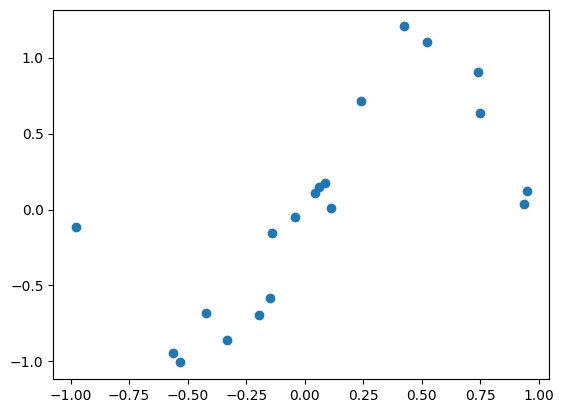

In [49]:
x_train = x_min + (x_max - x_min)*np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

mag_noise = 0.2
y_train = y_train+ mag_noise * np.random.randn(num_x_train)

plt.plot(x_train,y_train,"o")
plt.show()


In [50]:
from qulacs import QuantumState,QuantumCircuit

state = QuantumState(nqubit)
state.set_zero_state()

def U_in(x):
    U = QuantumCircuit(nqubit)
    
    angle_y = np.arcsin(x)
    angel_z = np.arccos(x**2)
    
    for i in range(nqubit):
        U.add_RY_gate(i,angle_y)
        U.add_RZ_gate(i,angel_z)

    return U

In [51]:
from qulacs.gate import X,Z,RX,RZ
I_mat = np.eye(2,dtype = complex)
X_mat = X(0).get_matrix()
Z_mat = Z(0).get_matrix()

In [52]:
def make_fullgate(list_SiteAndOperator,nqubit):
    list_Site = []
    for siteAndOperator in list_SiteAndOperator:
        list_Site.append(siteAndOperator[0])
        
    list_singleGate  =  []
    cnt = 0
    for i in range(nqubit):
        if(i in list_Site):
            list_singleGate.append(list_SiteAndOperator[cnt][1])
            cnt += 1
        else:
            list_singleGate.append(I_mat)
            
    return reduce(np.kron,list_singleGate)

In [53]:
ham = np.zeros((2**nqubit,2**nqubit),dtype = complex)
for i in range(nqubit):
    Jx = -1. + 2.*np.random.rand()
    ham += Jx * make_fullgate([[i,X_mat]],nqubit)
    for j in range(i):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate([[i,Z_mat],[j,Z_mat]],nqubit)
        
diag,eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs,np.diag(np.exp(-1j*time_step*diag))),eigen_vecs.T.conj())

In [54]:
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)],time_evol_op)

In [55]:
from qulacs import ParametricQuantumCircuit

U_out =  ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        

In [56]:
parameter_count = U_out.get_parameter_count()
U_out_gra0 = []
U_out_gra1 = []
for i in range(parameter_count):
    U_out_gra0.append(ParametricQuantumCircuit(nqubit))
    U_out_gra1.append(ParametricQuantumCircuit(nqubit))
    
angle = 0

for j in range(parameter_count):
    for d in range(c_depth):
        U_out_gra0[j].add_gate(time_evol_gate)
        for i in range(nqubit):
            
            if(3*nqubit*d + 3*i == j):
                U_out_gra0[j].add_parametric_RX_gate(i,np.pi/2)
            U_out_gra0[j].add_parametric_RX_gate(i,angle)
            
            if(3*nqubit*d + 3*i +1== j):
                U_out_gra0[j].add_parametric_RZ_gate(i,np.pi/2)
            U_out_gra0[j].add_parametric_RZ_gate(i,angle)
            
            if(3*nqubit*d + 3*i +2== j):
                U_out_gra0[j].add_parametric_RX_gate(i,np.pi/2)
            U_out_gra0[j].add_parametric_RX_gate(i,angle)    
            
            

for j in range(parameter_count):
    for d in range(c_depth):
        U_out_gra1[j].add_gate(time_evol_gate)
        for i in range(nqubit):
            
            if(3*nqubit*d + 3*i == j):
                U_out_gra1[j].add_parametric_RX_gate(i,-1*np.pi/2)
            U_out_gra1[j].add_parametric_RX_gate(i,angle)
            
            if(3*nqubit*d + 3*i +1== j):
                U_out_gra1[j].add_parametric_RZ_gate(i,-1*np.pi/2)
            U_out_gra1[j].add_parametric_RZ_gate(i,angle)
            
            if(3*nqubit*d + 3*i +2== j):
                U_out_gra1[j].add_parametric_RX_gate(i,-1*np.pi/2)
            U_out_gra1[j].add_parametric_RX_gate(i,angle)  


In [57]:
parameter_count = U_out.get_parameter_count()
print(parameter_count)
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]

120


In [58]:
def set_U_out(theta):
    global U_out
    parameter_count = U_out.get_parameter_count()
    for i in range(parameter_count):
        U_out.set_parameter(i,theta[i])

In [59]:
def set_U_out_gra(theta):
    global U_out_gra0
    global U_out_gra1
    for i in range(U_out.get_parameter_count()):
        for j in range(U_out.get_parameter_count()):
            if(j < i):
                U_out_gra0[i].set_parameter(j,theta[j])
                U_out_gra1[i].set_parameter(j,theta[j])
            
            else:
                U_out_gra0[i].set_parameter(j+1,theta[j])
                U_out_gra1[i].set_parameter(j+1,theta[j])

In [60]:
from qulacs import Observable
obs = Observable(nqubit)
obs.add_operator(2.,'Z 0')

In [61]:
def qcl_pred(x,U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()
    
    U_in(x).update_quantum_state(state)
    U_out.update_quantum_state(state)
    res = obs.get_expectation_value(state)
    
    return res

In [62]:
def cost_func(theta):
    set_U_out(theta)
    y_pred = [qcl_pred(x,U_out) for x in x_train]
    L = ((y_pred - y_train)**2).mean()
    return L

In [63]:
def cost_func_gra(theta):
    set_U_out(theta)
    set_U_out_gra(theta)
    y_pred = [qcl_pred(x,U_out) for x in x_train]
    L_grad = []
    
    for i in range(parameter_count):
        y_pred_gra0 = [qcl_pred(x,U_out_gra0[i]) for x in x_train]
        y_pred_gra1 = [qcl_pred(x,U_out_gra1[i]) for x in x_train]
        cost = []
        for j in range(num_x_train):
            cost.append((y_pred[j]- y_train[j])*(y_pred_gra0[j] - y_pred_gra1[j]))
        L_grad.append(statistics.mean(cost))
                           
    return L_grad

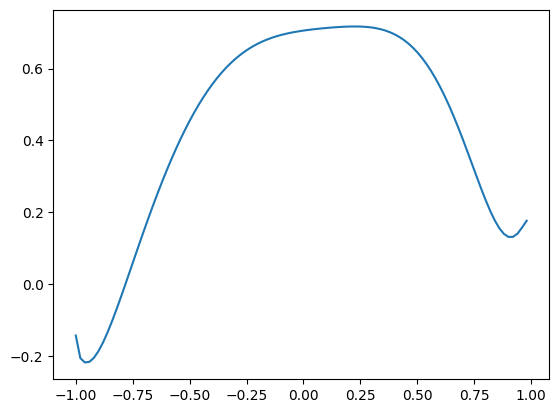

In [64]:
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x, U_out) for x in xlist]
plt.plot(xlist, y_init)

In [65]:
from scipy.optimize import minimize
result = minimize(cost_func,theta_init,jac=cost_func_gra, method='BFGS')

In [66]:
print(result.fun)
theta_opt = result.x
print(theta_opt)

0.014766502989893762
[ 6.18614732  2.10695816  3.9068816   4.31377868  2.70781291  2.80530459
 -0.36507823  0.1243211   2.50716745  3.06223439  1.30718745  3.39934926
  3.77843945  4.54742214  1.81038935  2.63266029  4.94829313  3.43330475
  4.40431351  3.21989724  5.34784073  4.52567429  5.57034436  1.04819072
  1.73421869  2.83541969  3.24760347  3.9352754   4.89302896  3.36145312
  6.10196086  3.94934234  1.01119665  3.74868062  3.59946753  5.18599721
  5.26086799  1.94004892  0.58103248  4.29729446  0.03650318  5.25096702
  3.31993936  6.39248266  6.38731274  1.51138031  5.78857301  5.28427034
  1.03618003  4.00277063  6.17849855  4.75841315  0.54484384  3.34231007
  2.91034339 -0.22140972  6.12944026  5.3526008   1.1156798   3.57698452
  3.43046744  2.40266348  3.1776952   3.73169821  5.07400258  0.40414086
  3.75277914  2.95547892  1.08626005  0.80237721  4.27094232  5.5863423
  0.09681159  2.56719456  5.46419476  3.46205648  2.64629649  1.15827703
  0.13306803  1.08070421  3.782

In [67]:
print(U_out.get_gate_count())

130


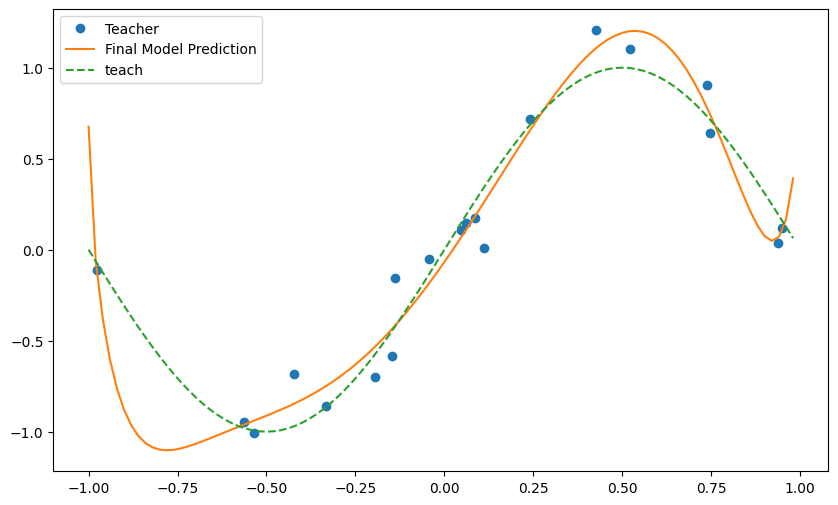

In [68]:
set_U_out(theta_opt)
plt.figure(figsize=(10,6))

plt.plot(x_train, y_train, "o", label='Teacher')

y_pred1 = [qcl_pred(x, U_out) for x in xlist]
y_pred2 = [func_to_learn(x) for x in xlist]
plt.plot(xlist, y_pred1, label='Final Model Prediction')
plt.plot(xlist, y_pred2, '--', label='teach')
#plt.plot(xlist, pred3, label='matrix')

plt.legend()
plt.show()

In [69]:
# ファイルを書き込みモードで開く
with open('x.txt', 'w') as f:
    for item in xlist:
        # リストの各要素を文字列に変換し、ファイルに書き込む
        f.write("%f\n" % item)